In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Load the MNIST dataset with as_supervised=True for (image, label) pairs
ds = tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True)

# Convert directly using tfds.as_numpy
all_images = []
all_labels = []

# Loop through each (image, label) pair
for image, label in tfds.as_numpy(ds):
    all_images.append(image)   # shape: (28, 28, 1)
    all_labels.append(label)   # scalar

# Convert to NumPy arrays
all_images = np.stack(all_images)   # shape: (60000, 28, 28, 1)
all_labels = np.array(all_labels)   # shape: (60000,)


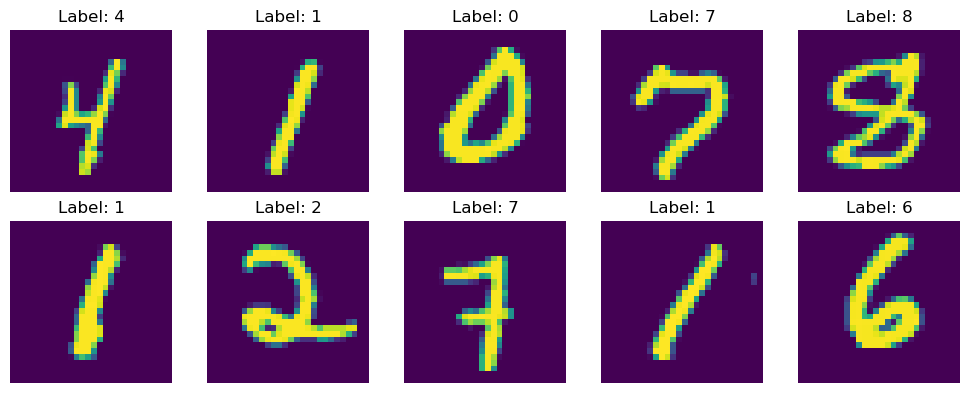

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(10):
    image, label = all_images[i], all_labels[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
all_images.shape

(60000, 28, 28, 1)

In [4]:
all_labels.shape

(60000,)

In [5]:
all_labels

array([4, 1, 0, ..., 6, 1, 5], dtype=int64)

In [6]:
flattened_images = all_images.reshape(60000, -1)
one_hot_labels=tf.keras.utils.to_categorical(all_labels,num_classes=10)
one_hot_labels=one_hot_labels.astype(np.float32)


In [7]:
one_hot_labels.shape

(60000, 10)

In [8]:
flattened_images.shape

(60000, 784)

In [9]:
def initialize_parameters(layers, activations):
    params = {}
    vdw = {}
    vdb = {}
    sdw = {}
    sdb = {}

    for l in range(1, len(layers)):
        # Weight initialization
        if activations[l-1] == 'relu':
            std_dev = np.sqrt(2. / layers[l-1])  # He init
        elif activations[l-1] in ['no activation', 'softmax']:
            std_dev = np.sqrt(1. / layers[l-1])  # Xavier init
        else:
            raise ValueError(f"Unsupported activation type {activations[l-1]}")

        params[f'w{l}'] = np.random.randn(layers[l-1], layers[l]) * std_dev
        params[f'b{l}'] = np.zeros((1, layers[l]))

        # Adam optimizer variables
        vdw[f'w{l}'] = np.zeros_like(params[f'w{l}'])
        vdb[f'b{l}'] = np.zeros_like(params[f'b{l}'])
        sdw[f'w{l}'] = np.zeros_like(params[f'w{l}'])
        sdb[f'b{l}'] = np.zeros_like(params[f'b{l}'])

    return params, vdw, vdb, sdw, sdb


In [10]:
def forward(a, w, b, activation, keep_n=0.9):
    z = np.dot(a, w) + b

    if activation == 'relu':
        a = np.maximum(0, z)
        # Apply dropout
        m, n = a.shape
        D = (np.random.rand(m, n) < keep_n).astype(int)
        a = (a * D) / keep_n  # inverted dropout
    elif activation == 'softmax':
        z_exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        a = z_exp / np.sum(z_exp, axis=1, keepdims=True)
        D = None  # No dropout in output layer
    else:
        raise ValueError(f"Unsupported activation: {activation}")

    return a, z, D


In [11]:
def T_cost(a, y,params=None,LAMBDA=0.001):
   
    # Small epsilon value to prevent log(0)
    epsilon = 1e-10
    cost = -np.sum(y * np.log(a + epsilon))
    Sl2=0
    if params is not None:
      for key in params:
        if key.startswith('w'):
            Sl2 +=  np.sum(np.square(params[key]))
      Ll2=(LAMBDA/(2))*Sl2
    T_cost=cost+Ll2
    return np.squeeze(T_cost)

In [12]:
def backward(w, dz, a_pre, activation, m, lambd=0.001, D=None, keep_n=0.9):
    # Gradient of activation w.r.t previous layer
    da_pre = np.dot(dz, w.T)

    # Apply dropout if D is given (only in hidden layers like ReLU)
    if D is not None and activation == 'relu':
        da_pre = (da_pre * D) / keep_n

    # Gradient of weights and biases with L2 regularization
    dw = (np.dot(a_pre.T, dz) / m) + (lambd * w / m)
    db = np.sum(dz, axis=0, keepdims=True) / m

    # Derivative for previous layer
    if activation == 'relu':
        dz_pre = da_pre * (a_pre > 0)
    elif activation == 'no activation':
        dz_pre = da_pre  # linear passthrough
    else:
        raise ValueError(f"Unsupported activation: {activation}")

    return dz_pre, dw, db


In [13]:
def learning_rate_decay(iterarion,decayrate=0.1,LR0=0.01,level=1000):
    return LR0 * np.exp(-decayrate * np.floor(iterarion/level))

In [14]:
def update(w, dw, b, db, learning_rate=0.01,vdw=None,vdb=None,beta1=0.9,beta2=0.99,t=1,sdw=None,sdb=None):
    epsilon = 1e-10
    
    vdw=beta1*vdw+(1-beta1)*dw
    vdw_corrected=vdw/(1-beta1**t)
    vdb=beta1*vdb+(1-beta1)*db
    vdb_corrected=vdb/(1-beta1**t)

    
    sdw=beta2*sdw+(1-beta2)*(dw**2)
    sdw_corrected=sdw/(1-beta2**t)    
    sdb=beta2*sdb+(1-beta2)*(db**2)
    sdb_corrected=sdb/(1-beta2**t)
    
    w -= learning_rate * vdw_corrected/(np.sqrt(sdw_corrected)+epsilon)
    b -= learning_rate * vdb_corrected/(np.sqrt(sdb_corrected)+epsilon)
    return w, b,vdw,vdb,sdw,sdb

In [15]:
def batch(x, y, size=128):
    m = x.shape[0]
    batches = []
    number_batches = int(np.floor(m / size))

    for i in range(number_batches):
        batch_x = x[i * size : (i + 1) * size]
        batch_y = y[i * size : (i + 1) * size]
        batches.append((batch_x, batch_y))

    # Handle the last remaining data (if not divisible evenly)
    if m % size != 0:
        batch_x = x[number_batches * size :]
        batch_y = y[number_batches * size :]
        batches.append((batch_x, batch_y))

    return batches

In [16]:
def nn(layers, activations, iterations, x, y,
       batch_size=128, learning_rate=0.01, decayrate=0.1, learning_rate_level=1000,
       lambd=0.001, keep_n=0.9, beta1=0.9, beta2=0.99):

    total_start_time = time.time()
    log_start_time = time.time()

    params, vdw, vdb, sdw, sdb = initialize_parameters(layers, activations)
    costs = np.empty((0, 4), float)  # Columns: [iteration, avg_cost, learning_rate, elapsed_time]
    step = max(iterations // 25, 1)
    t = 1  # Adam timestep

    for i in range(iterations + 1):
        batches = batch(x, y, size=batch_size)
        lr = learning_rate_decay(i, decayrate, LR0=learning_rate, level=learning_rate_level)

        for x_batch, y_batch in batches:
            m_batch = x_batch.shape[0]
            cache = {'a0': x_batch}

            # Forward pass
            for l in range(1, len(layers)):
                cache[f'a{l}'], cache[f'z{l}'], cache[f'D{l}'] = forward(
                    cache[f'a{l-1}'],
                    params[f'w{l}'], params[f'b{l}'],
                    activation=activations[l],
                    keep_n=keep_n
                )

            # Backward pass
            dz = cache[f'a{len(layers)-1}'] - y_batch
            for l in range(len(layers) - 1, 0, -1):
                dz, dw, db = backward(
                    params[f'w{l}'], dz,
                    cache[f'a{l-1}'],
                    activation=activations[l-1],
                    m=m_batch, lambd=lambd,
                    D=cache.get(f'D{l-1}'),
                    keep_n=keep_n
                )

                # Adam update
                params[f'w{l}'], params[f'b{l}'], \
                vdw[f'w{l}'], vdb[f'b{l}'], \
                sdw[f'w{l}'], sdb[f'b{l}'] = update(
                    params[f'w{l}'], dw,
                    params[f'b{l}'], db,
                    lr,
                    vdw[f'w{l}'], vdb[f'b{l}'],
                    beta1, beta2, t,
                    sdw[f'w{l}'], sdb[f'b{l}']
                )

            t += 1

        # Evaluation and logging
        if i % step == 0 or i == iterations:
            # Full forward pass over entire training set with dropout disabled
            a_eval = x
            for l in range(1, len(layers)):
                a_eval, _, _ = forward(
                    a_eval,
                    params[f'w{l}'], params[f'b{l}'],
                    activation=activations[l],
                    keep_n=1.0  # disable dropout for evaluation
                )

            computed_cost = T_cost(a_eval, y, params, LAMBDA=0)
            avg_cost = computed_cost / y.shape[0]
            elapsed = time.time() - total_start_time

            # Store log
            costs = np.append(costs, np.array([[i, avg_cost, lr, elapsed]]), axis=0)

            # Print log
            log_end_time = time.time()
            print(f"Iteration {i:5d} | Avg Cost: {avg_cost:.4f} | LR: {lr:.6f} | Time: {(log_end_time - log_start_time):.2f} sec")
            log_start_time = time.time()

    total_end_time = time.time()
    print(f"\nTotal Training Time: {(total_end_time - total_start_time):.2f} seconds")

    return params, cache, costs


In [17]:
from sklearn.metrics import f1_score

def predict_cost_accuracy(x, y, params, layers, activations):
    a = x
    for l in range(1, len(layers)):
        a, _, _ = forward(a, params['w' + str(l)], params['b' + str(l)], activations[l], keep_n=1)

    # Compute cost
    computed_cost = T_cost(a, y, params,LAMBDA=0)
    print("Cost:", computed_cost / x.shape[0])  # Per-sample cost

    # Predictions: argmax over output layer
    predictions = np.argmax(a, axis=1)

    # True labels: convert from one-hot if necessary
    y_true = np.argmax(y, axis=1) if y.ndim > 1 else y

    # Accuracy
    accuracy = np.mean(predictions == y_true)

    # F1 Score (macro treats all classes equally)
    f1 = f1_score(y_true, predictions, average='macro')

    return predictions, accuracy, f1


In [18]:
import time
# Split data
train_size = int(flattened_images.shape[0] * 0.75)
test_size = flattened_images.shape[0] - train_size

x_train = flattened_images[:train_size, :]
x_test = flattened_images[train_size:, :]
y_train = one_hot_labels[:train_size, :]
y_test = one_hot_labels[train_size:, :]

In [22]:
# Define architecture
layers = [784, 128, 32, 10]
activations = {
    0: 'no activation',
    1: 'relu',
    2: 'relu',
    3: 'softmax'
}

# Start timer
start_time = time.time()

# Train the network
params, cache, costs = nn(
    layers, activations,
    iterations=2500,
    x=x_train, y=y_train,
    batch_size=128,
    learning_rate=0.01,
    decayrate=0.1,
    learning_rate_level=100,
    lambd=0.001,
    keep_n=0.85,
    beta1=0.9,
    beta2=0.99
)

# End timer
end_time = time.time()
training_time = end_time - start_time

# Evaluate
predictions_train, accuracy_train, f1_train = predict_cost_accuracy(x_train, y_train, params, layers, activations)
predictions_test, accuracy_test, f1_test = predict_cost_accuracy(x_test, y_test, params, layers, activations)

print("Train Accuracy:", accuracy_train * 100, "%")
print("Train F1 Score:", f1_train * 100, "%")
print("Test Accuracy:", accuracy_test * 100, "%")
print("Test F1 Score:", f1_test * 100, "%")
print(f"Total Training Time: {training_time:.2f} seconds")


Iteration     0 | Avg Cost: 2.0964 | LR: 0.010000 | Time: 2.62 sec
Iteration   100 | Avg Cost: 2.0492 | LR: 0.009048 | Time: 169.67 sec
Iteration   200 | Avg Cost: 2.0001 | LR: 0.008187 | Time: 171.09 sec
Iteration   300 | Avg Cost: 1.9958 | LR: 0.007408 | Time: 174.72 sec
Iteration   400 | Avg Cost: 0.1793 | LR: 0.006703 | Time: 162.81 sec
Iteration   500 | Avg Cost: 0.1591 | LR: 0.006065 | Time: 153.76 sec
Iteration   600 | Avg Cost: 0.1452 | LR: 0.005488 | Time: 156.34 sec
Iteration   700 | Avg Cost: 0.1353 | LR: 0.004966 | Time: 157.02 sec
Iteration   800 | Avg Cost: 0.1174 | LR: 0.004493 | Time: 159.08 sec
Iteration   900 | Avg Cost: 0.1105 | LR: 0.004066 | Time: 165.29 sec
Iteration  1000 | Avg Cost: 0.1039 | LR: 0.003679 | Time: 161.87 sec
Iteration  1100 | Avg Cost: 0.0992 | LR: 0.003329 | Time: 156.27 sec
Iteration  1200 | Avg Cost: 0.0913 | LR: 0.003012 | Time: 155.36 sec
Iteration  1300 | Avg Cost: 0.0695 | LR: 0.002725 | Time: 156.98 sec
Iteration  1400 | Avg Cost: 0.0759 |

In [23]:
costs

array([[0.00000000e+00, 2.09635445e+00, 1.00000000e-02, 2.61517715e+00],
       [1.00000000e+02, 2.04923758e+00, 9.04837418e-03, 1.72287891e+02],
       [2.00000000e+02, 2.00007722e+00, 8.18730753e-03, 3.43379286e+02],
       [3.00000000e+02, 1.99584507e+00, 7.40818221e-03, 5.18095108e+02],
       [4.00000000e+02, 1.79318325e-01, 6.70320046e-03, 6.80902341e+02],
       [5.00000000e+02, 1.59102523e-01, 6.06530660e-03, 8.34658620e+02],
       [6.00000000e+02, 1.45244087e-01, 5.48811636e-03, 9.90997713e+02],
       [7.00000000e+02, 1.35301486e-01, 4.96585304e-03, 1.14801857e+03],
       [8.00000000e+02, 1.17402691e-01, 4.49328964e-03, 1.30710077e+03],
       [9.00000000e+02, 1.10497143e-01, 4.06569660e-03, 1.47239415e+03],
       [1.00000000e+03, 1.03911176e-01, 3.67879441e-03, 1.63426283e+03],
       [1.10000000e+03, 9.91878757e-02, 3.32871084e-03, 1.79052807e+03],
       [1.20000000e+03, 9.13446538e-02, 3.01194212e-03, 1.94588743e+03],
       [1.30000000e+03, 6.94845393e-02, 2.72531793e

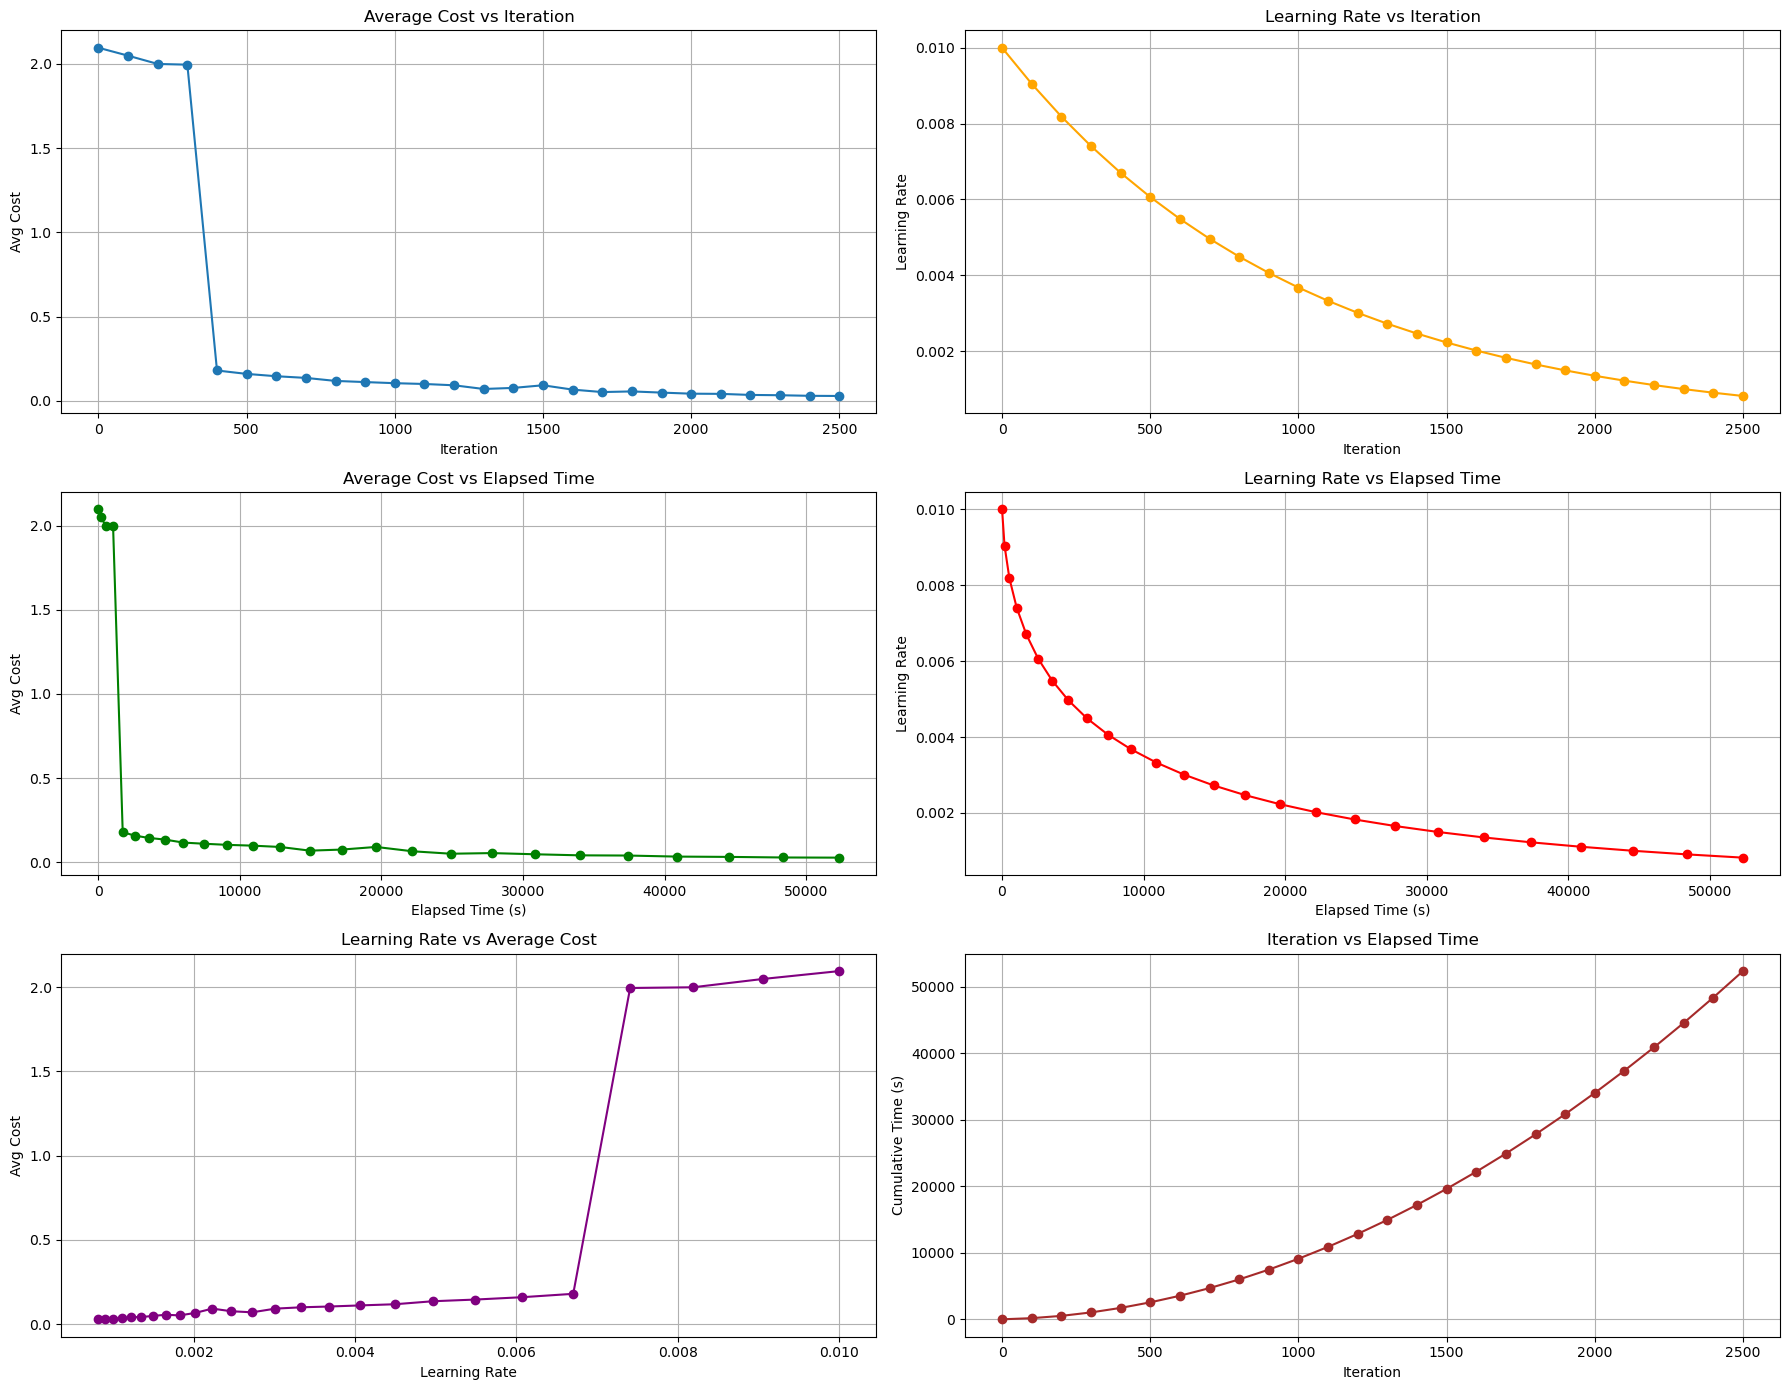

In [33]:
# Assuming `costs` is a NumPy array with shape (N, 4)
# Columns: [iteration, avg_cost, learning_rate, elapsed_time]

iterations = costs[:, 0]
avg_costs = costs[:, 1]
learning_rates = costs[:, 2]
elapsed_times = np.cumsum(costs[:, 3])  # Cumulative elapsed time

plt.figure(figsize=(18, 14))

# 1. Cost vs Iteration
plt.subplot(3, 2, 1)
plt.plot(iterations, avg_costs, marker='o')
plt.title("Average Cost vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Avg Cost")
plt.grid(True)

# 2. Learning Rate vs Iteration
plt.subplot(3, 2, 2)
plt.plot(iterations, learning_rates, marker='o', color='orange')
plt.title("Learning Rate vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.grid(True)

# 3. Cost vs Elapsed Time
plt.subplot(3, 2, 3)
plt.plot(elapsed_times, avg_costs, marker='o', color='green')
plt.title("Average Cost vs Elapsed Time")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Avg Cost")
plt.grid(True)

# 4. Learning Rate vs Elapsed Time
plt.subplot(3, 2, 4)
plt.plot(elapsed_times, learning_rates, marker='o', color='red')
plt.title("Learning Rate vs Elapsed Time")
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Learning Rate")
plt.grid(True)

# 5. Learning Rate vs Average Cost
plt.subplot(3, 2, 5)
plt.plot(learning_rates, avg_costs, marker='o', color='purple')
plt.title("Learning Rate vs Average Cost")
plt.xlabel("Learning Rate")
plt.ylabel("Avg Cost")
plt.grid(True)

# 6. Iteration vs Elapsed Time
plt.subplot(3, 2, 6)
plt.plot(iterations, elapsed_times, marker='o', color='brown')
plt.title("Iteration vs Elapsed Time")
plt.xlabel("Iteration")
plt.ylabel("Cumulative Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [264]:
class CustomLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_interval=100):
        super().__init__()
        self.log_interval = log_interval
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.last_logged_time = self.start_time

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_interval == 0 or (epoch + 1) == self.params['epochs']:
            now = time.time()
            elapsed = now - self.last_logged_time
            self.last_logged_time = now

            # Correct way to access the current learning rate
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

            print(f"Epoch {epoch + 1}: "
                  f"loss = {logs['loss']:.4f}, "
                  f"accuracy = {logs['accuracy']:.4f}, "
                  f"val_loss = {logs['val_loss']:.4f}, "
                  f"val_accuracy = {logs['val_accuracy']:.4f}, "
                  f"lr = {lr:.6f}, "
                  f"interval_time = {elapsed:.2f} sec")


In [113]:

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(784,)),
    tf.keras.layers.Rescaling(1./255),  # Automatically scales pixel values from [0,255] to [0,1]
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(10, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))
])


# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.95
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
start_time = time.time()
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=250,
    validation_data=(x_test, y_test),
    verbose=0,
    callbacks=[CustomLogger(log_interval=5)]
)
training_time = time.time() - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


Epoch 5: loss = 0.4917, accuracy = 0.9200, val_loss = 0.4262, val_accuracy = 0.9441, lr = 0.009137, interval_time = 22.15 sec
Epoch 10: loss = 0.4714, accuracy = 0.9227, val_loss = 0.4022, val_accuracy = 0.9399, lr = 0.008348, interval_time = 22.68 sec
Epoch 15: loss = 0.4448, accuracy = 0.9286, val_loss = 0.3742, val_accuracy = 0.9480, lr = 0.007627, interval_time = 25.93 sec
Epoch 20: loss = 0.4313, accuracy = 0.9296, val_loss = 0.3869, val_accuracy = 0.9433, lr = 0.006969, interval_time = 22.02 sec
Epoch 25: loss = 0.4179, accuracy = 0.9313, val_loss = 0.3738, val_accuracy = 0.9456, lr = 0.006367, interval_time = 22.46 sec
Epoch 30: loss = 0.3984, accuracy = 0.9353, val_loss = 0.3502, val_accuracy = 0.9514, lr = 0.005818, interval_time = 24.31 sec
Epoch 35: loss = 0.3852, accuracy = 0.9381, val_loss = 0.3301, val_accuracy = 0.9520, lr = 0.005316, interval_time = 23.92 sec
Epoch 40: loss = 0.3727, accuracy = 0.9403, val_loss = 0.3182, val_accuracy = 0.9558, lr = 0.004857, interval_ti

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train F1 Score: 98.53 %
Test F1 Score: 97.03 %


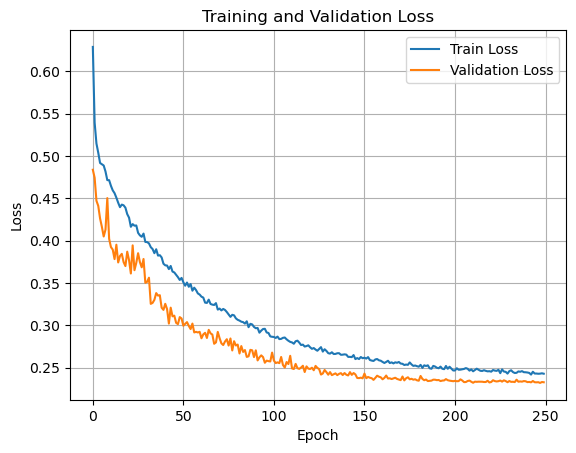

In [115]:
y_train_pred = tf.argmax(model.predict(x_train), axis=1).numpy()
y_test_pred = tf.argmax(model.predict(x_test), axis=1).numpy()
y_train_true = tf.argmax(y_train, axis=1).numpy()
y_test_true = tf.argmax(y_test, axis=1).numpy()

f1_train = f1_score(y_train_true, y_train_pred, average='macro') * 100
f1_test = f1_score(y_test_true, y_test_pred, average='macro') * 100

print(f"Train F1 Score: {f1_train:.2f} %")
print(f"Test F1 Score: {f1_test:.2f} %") 

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [310]:

import warnings
warnings.filterwarnings('ignore')

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(784,)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='relu',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.15),
    #tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(10, activation='softmax',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.96
)

# Checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=0
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
start_time = time.time()
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=300,
    validation_data=(x_test, y_test),
    verbose=0,
    callbacks=[CustomLogger(log_interval=5), checkpoint_callback]
)
training_time = time.time() - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


Epoch 5: loss = 0.5071, accuracy = 0.9219, val_loss = 0.4707, val_accuracy = 0.9325, lr = 0.009307, interval_time = 47.54 sec
Epoch 10: loss = 0.4724, accuracy = 0.9257, val_loss = 0.4264, val_accuracy = 0.9391, lr = 0.008662, interval_time = 36.76 sec
Epoch 15: loss = 0.4531, accuracy = 0.9264, val_loss = 0.3807, val_accuracy = 0.9464, lr = 0.008061, interval_time = 47.20 sec
Epoch 20: loss = 0.4313, accuracy = 0.9292, val_loss = 0.3621, val_accuracy = 0.9474, lr = 0.007502, interval_time = 51.62 sec
Epoch 25: loss = 0.4240, accuracy = 0.9298, val_loss = 0.3702, val_accuracy = 0.9481, lr = 0.006982, interval_time = 51.64 sec
Epoch 30: loss = 0.4160, accuracy = 0.9298, val_loss = 0.3602, val_accuracy = 0.9472, lr = 0.006498, interval_time = 51.62 sec
Epoch 35: loss = 0.3927, accuracy = 0.9346, val_loss = 0.3337, val_accuracy = 0.9539, lr = 0.006048, interval_time = 41.15 sec
Epoch 40: loss = 0.3840, accuracy = 0.9364, val_loss = 0.3375, val_accuracy = 0.9526, lr = 0.005628, interval_ti

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1434
           1       0.97      0.98      0.98      1709
           2       0.97      0.96      0.97      1494
           3       0.96      0.96      0.96      1588
           4       0.97      0.97      0.97      1476
           5       0.98      0.96      0.97      1320
           6       0.98      0.98      0.98      1483
           7       0.97      0.98      0.97      1575
           8       0.97      0.95      0.96      1451
           9       0.96      0.96      0.96      1470

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000

Train F1 Score: 98.45 %
Test F1 Score: 96.90 %


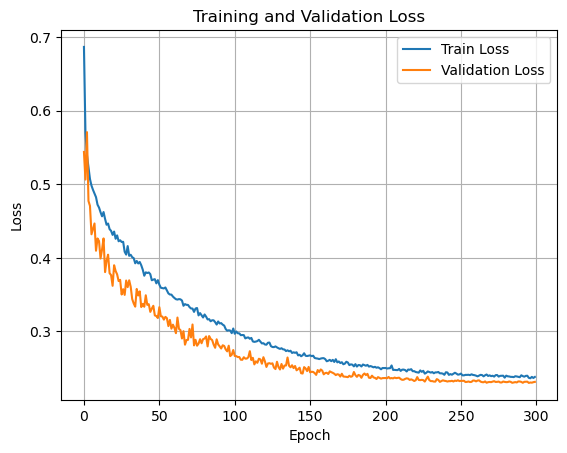

In [312]:
y_train_pred = tf.argmax(model.predict(x_train), axis=1).numpy()
y_test_pred = tf.argmax(model.predict(x_test), axis=1).numpy()
y_train_true = tf.argmax(y_train, axis=1).numpy()
y_test_true = tf.argmax(y_test, axis=1).numpy()

from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_test_pred))


f1_train = f1_score(y_train_true, y_train_pred, average='macro') * 100
f1_test = f1_score(y_test_true, y_test_pred, average='macro') * 100

print(f"Train F1 Score: {f1_train:.2f} %")
print(f"Test F1 Score: {f1_test:.2f} %") 

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [314]:
model = tf.keras.models.load_model('best_model.keras')


In [316]:
import cv2

def preprocess_image(filepath):
    # 1. Load in grayscale and invert
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.bitwise_not(img)

    # 2. Blur and threshold
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Find bounding box
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        digit = binary[y:y+h, x:x+w]
    else:
        digit = binary

    # 4. Resize keeping aspect ratio to 20x20
    h, w = digit.shape
    if h > w:
        new_h = 20
        new_w = int(w * (20 / h))
    else:
        new_w = 20
        new_h = int(h * (20 / w))
    digit = cv2.resize(digit, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 5. Place resized digit in center of 28x28 black image
    new_img = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    new_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = digit

    # 6. Flatten but do NOT normalize — handled by model
    return new_img.reshape(1, 784).astype("float32")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

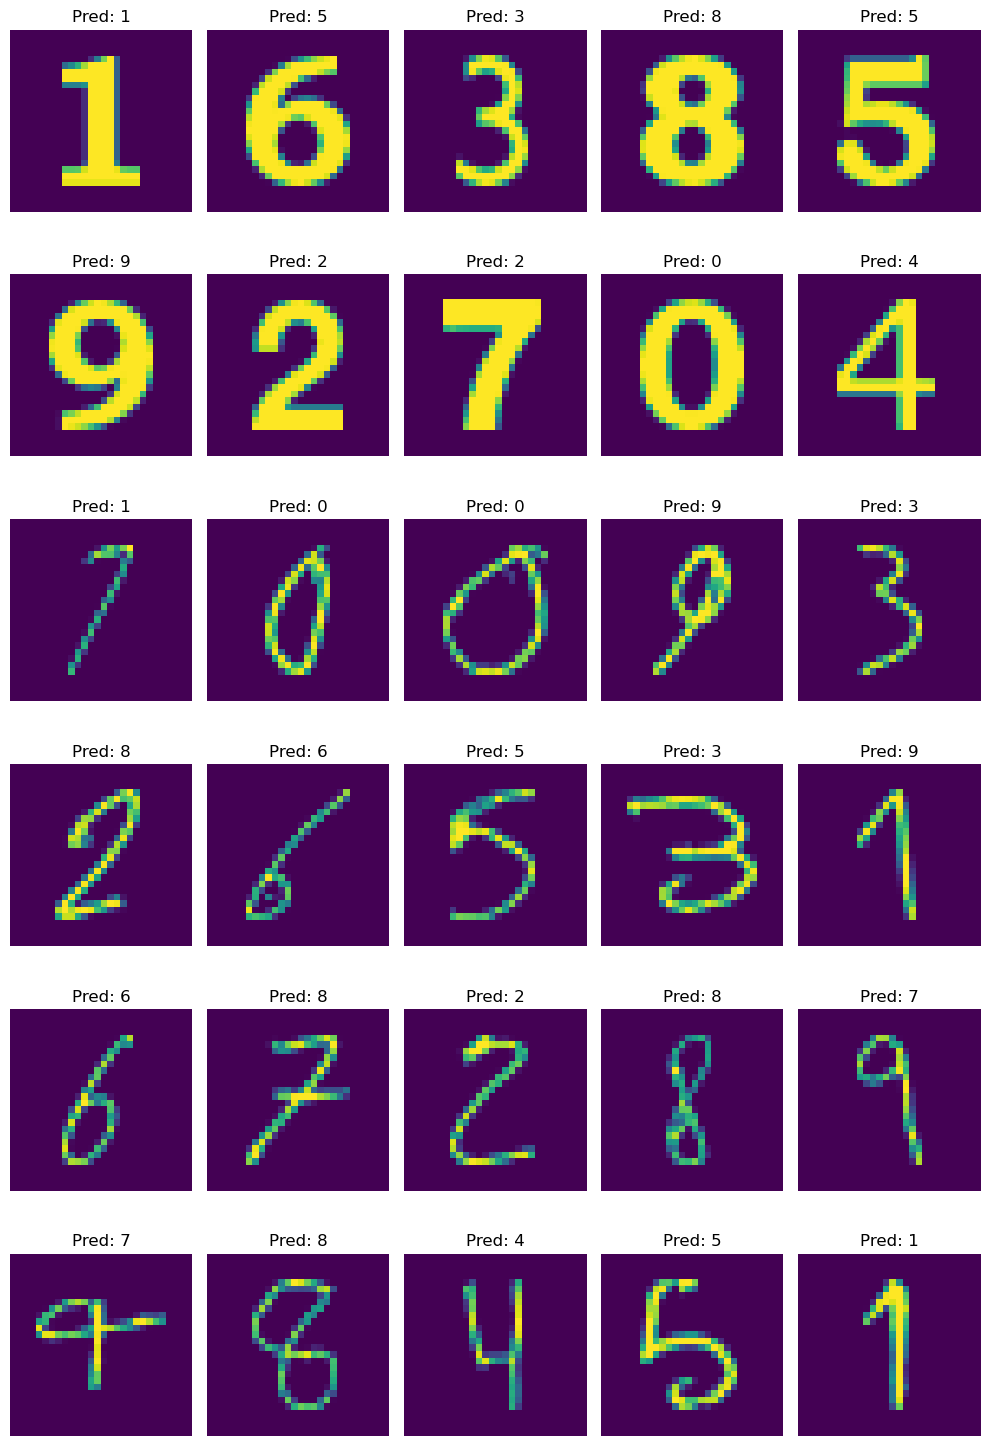

In [326]:
import os

folder_path = r'E:\ocr-git\dev-test'
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_files = image_files[:30]  # Limit to 20 for the grid

plt.figure(figsize=(10, 15))
for i, filename in enumerate(image_files):
    filepath = os.path.join(folder_path, filename)
    input_image = preprocess_image(filepath)
    pred = model.predict(input_image)
    label = np.argmax(pred)

    plt.subplot(6, 5, i+1)
    plt.imshow(input_image.reshape(28, 28))
    plt.title(f"Pred: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
